<a href="https://colab.research.google.com/github/halen48/image-processing/blob/main/Segmenta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

```
Neste notebook iremos estudar algumas formas de segmentação.
```

In [ ]:
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
!wget https://entusiastanerd.com.br/wp-content/uploads/2022/02/explicado-o-atraso-do-capitulo-1035-e-a-nova-data-de-lancamento.jpg -O imagem.jpg -q
imagem = Image.open("imagem.jpg")
imagem

#Segmentações clássicas

##Pillow para OpenCV faz a imagem ser de RGB para BGR, logo, precisamos inverter

```
É importante notar que toda segmentação atua em tons de cinza, logo, é necessário isolar apenas um único canal para a segmentação!
```

In [ ]:
imagem = np.array(imagem)
imagem = imagem[:,:,::-1]

##Por limiar de valor fixo

```
Insere-se um valor para criar a segmentação.
Tudo abaixo desse valor é o valor mínimo (ex: 0), tudo acima é o valor máximo (ex: 255)
```

In [ ]:
def value_threshold(imagem, valor, canal = 0):

  if(canal > imagem.shape[-1]):
    raise Exception("Canal %d não existe na imagem! (Shape: %s)"%(canal, imagem.shape))

  #Vamos segmentar apenas um canal
  seg_val = imagem[:,:,canal].copy()

  seg_val[seg_val<valor] = 0
  seg_val[seg_val>=valor] = 255
  
  return seg_val
#Vamos usar a média como limiar de segmentação
seg_val = value_threshold(imagem, np.mean(imagem))
cv2_imshow(seg_val)

In [ ]:
#@title Como remover artefatos?
artefato = seg_val[60:130,230:300]
cv2_imshow(artefato)

```
Artefatos são "sujeiras" indesejadas que temos nas imagens.
Existem algumas tecnicas que podemos fazer para mitigar os artefatos.
Como a segmentação é sensível ao ruído, preciamos reduzi-lo. Assim:
```

In [ ]:
tamanho_janela = 3 #@param {type:"slider", min:3, max:11, step:2}

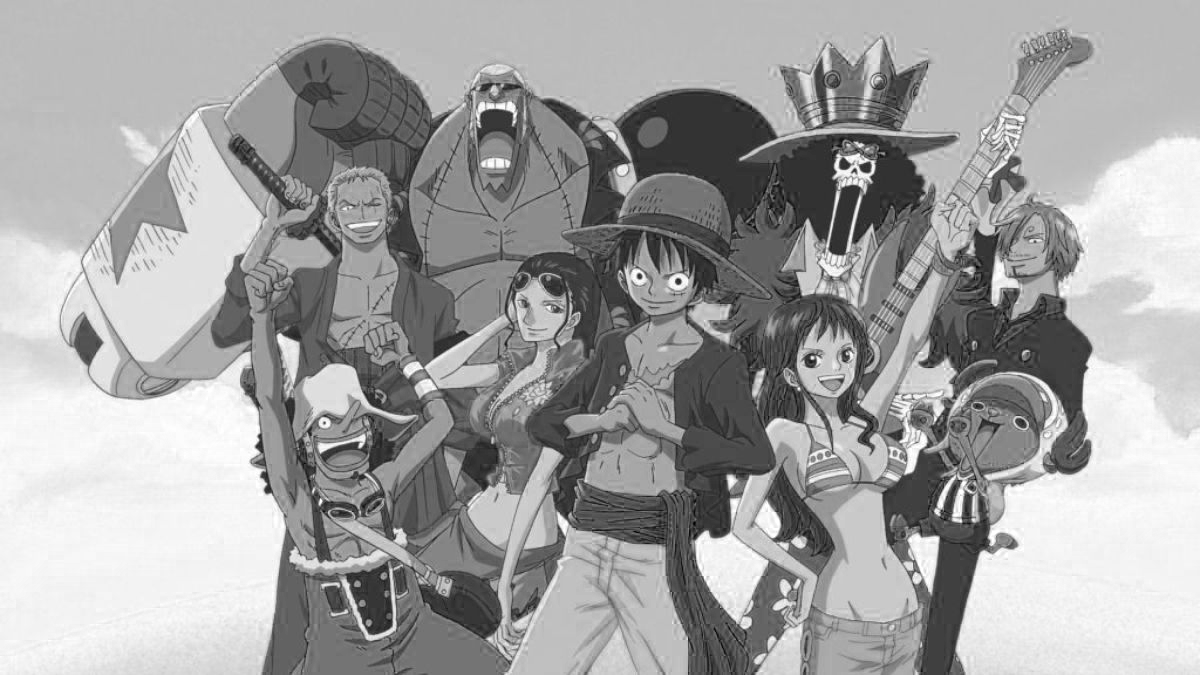

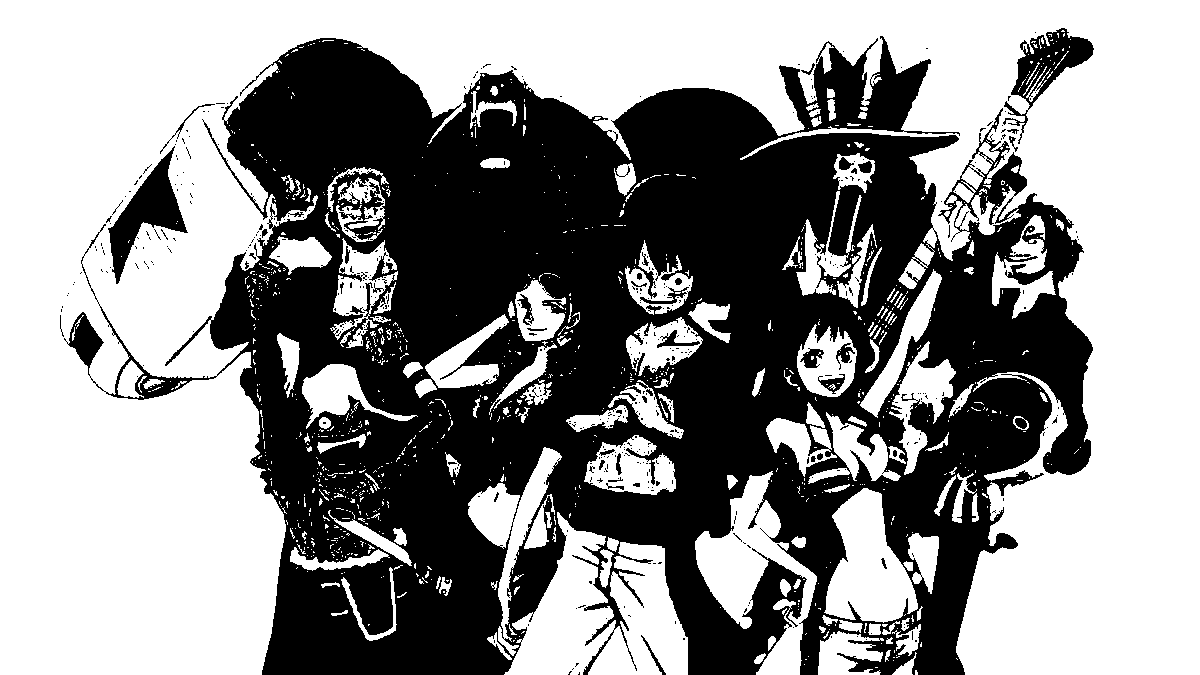

In [ ]:
seg_val = imagem[:,:,0]

def blur_media(imagem,janela):
  janela //= 2
  imagem_blur = np.zeros((imagem.shape[0], imagem.shape[1], 1))
  for x in range(imagem.shape[0]):
    for y in range(imagem.shape[1]):
      imagem_blur[x,y] = (imagem[x:x+janela,y:y+janela]).mean()
  
  return imagem_blur.astype(int)

cv2_imshow(seg_val)
seg_val = blur_media(seg_val,tamanho_janela)
cv2_imshow(seg_val)
seg_val = value_threshold(seg_val, np.mean(seg_val))
cv2_imshow(seg_val)

In [ ]:
def diferenca_imagens(a,b, texto = False):
  valor = (abs(a/255-b/255).mean())
  if(texto):
    print("%.3f%% dos pixels das duas imagens são diferentes"%(valor*100))
  else:
    return valor

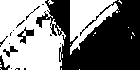

44.796% dos pixels das duas imagens são diferentes


In [ ]:
#@title Veja a diferença
cv2_imshow(np.concatenate([artefato,seg_val[60:130,230:300]], axis = 1))
diferenca_imagens(artefato,seg_val[60:130,230:300], True)

##Por limiar de <a href="https://en.wikipedia.org/wiki/Otsu%27s_method">Otsu</a>

In [ ]:
seg_mediana = value_threshold(imagem, np.mean(seg_val))

2.193% dos pixels das duas imagens são diferentes


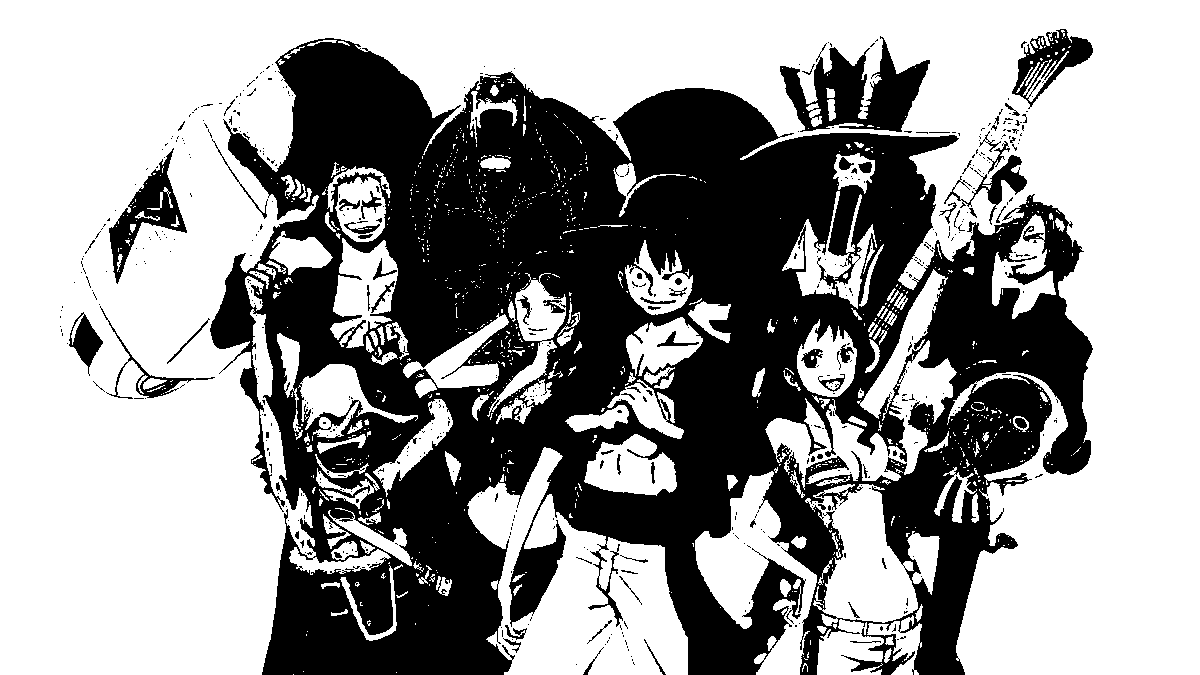

In [ ]:
import cv2
_,otsu = cv2.threshold(imagem[:,:,0],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
diferenca_imagens(otsu,seg_mediana, True)
cv2_imshow(otsu)

#Segmentação por Aprendizagem de Máquina

```
O processo de segmentação pode ser descrito como um processo de classificação de 
pixels em dois grupos: pretos e brancos.
Assim, diversas tecnicas de classificação na área de aprendizagem de máquina podem
ser aplicadas para resolver esse tipo de problema
```

#SVM

```
Para nosso exemplo, vamos fazer o computador aprender a segmentação de Otsu. 
(Em uma aplicação real, geralmente a segmentação aprendida é baseada em segmentações manuais,
ou seja, uma pessoa segmenta várias imagens e o computador aprende o padrão.)
```

In [ ]:
from sklearn import svm
clf = svm.SVC()
_,mascara = cv2.threshold(imagem[:,:,0],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
clf.fit(imagem[:,:,0].reshape(-1, 1), mascara.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
a = imagem[:,:,0].reshape(-1,1)
svm = clf.predict(a).reshape(imagem[:,:,0].shape)

In [ ]:
diferenca_imagens(otsu,svm, True)
cv2_imshow(svm)